原文: http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Translator: 陳胤泰 YinTaiChen

# 訓練一個分類器

時候到了。你已經見識到該如何定義神經網路,計算損失與更新神經網路的權重。

現在,你可能正在想......

## 該怎麼處理資料?

一般而言,當你必須處理圖像,文字,音訊或視訊檔案,你可以使用標準的Python套件,把資料以numpy array的形式載入.接著你可以將array轉換為 torch.*Tensor

* 如果是圖像,像是Pillow或OpenCV這些套件很有用

* 如果是音訊,會用到scipy與librosa

* 如果是文字,若非單純只用Python或是基於Cython的載入,你會發現NTLK和SpaCy很管用

特別針對vision,我們創造了一個名為torchvision的套件，具有常用資料集的data loader,包括ImageNet, CIFAR10, MNIST等等.也具有為圖像資料設計的data transformer。它們分別是torchvision.datasets以及torch.utils.data.Dataloader.

這提供了非常大的方便,也避免一再寫下一成不變的程式碼.

在這次的教學之中,我們會使用CIFAR10資料集。它具有飛機,汽車,鳥,貓,鹿,狗,蛙,馬,羊,卡車這些類別。CIFAR10中的圖片大小為3x32x32,也就是通道(channel)數為三,像素量為32*32.

![title](http://pytorch.org/tutorials/_images/cifar10.png)

## 訓練一個圖像分類器

我們會依序進行以下步驟:

1. 使用torchvision來載入並正規化(normalize)CIFAR10訓練集與測試集.
2. 定義一個捲積神經網路
3. 定義一個損失函數
4. 以訓練集訓練神經網路
5. 以測試集測試神經網路

## 載入並正規化CIFAR10

使用torchvision,載入CIFAR10便是件輕而易舉的事情.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision資料集的輸出是值域在[0,1]之間的PILImage.我們將它轉為正規化後值域介於[-1,1]之間的張量.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


讓我們顯示一些訓練圖片,只是為了好玩.

  car horse  deer  bird


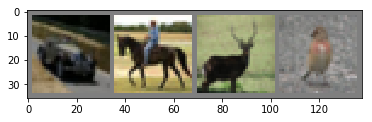

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. 定義卷積神經網路

從之前的神經網路教學中複製神經網路,並將它修改成可以接受3通道圖像作為輸入（而不是原先定義的1通道圖像）.

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3. 定義損失函數與優化器(optimizer）

讓我們使用分類用的交叉熵損失函數(cross-entropy loss）以及帶有momentum的SGD.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 訓練神經網路

事情開始變得有趣了.我們只需讓資料迭代器(data iterator）不斷迭代,將輸入餵給神經網路並進行(權重的)優化

In [6]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss=0.0
        
print('Finished Training')

[1,  2000] loss: 2.213
[1,  4000] loss: 1.928
[1,  6000] loss: 1.730
[1,  8000] loss: 1.620
[1, 10000] loss: 1.559
[1, 12000] loss: 1.494
[2,  2000] loss: 1.415
[2,  4000] loss: 1.390
[2,  6000] loss: 1.364
[2,  8000] loss: 1.346
[2, 10000] loss: 1.316
[2, 12000] loss: 1.277
Finished Training


## 5. 以測試資料測試神經網路

我們以訓練資料集將神經網路訓練了兩次.但我們需要檢查一下神經網路是否有學到任何東西.

我們以這樣的方式來測試:根據神經網路的輸出預測它的類別,並拿它與 ground truth 相較. 如果預測正確,將該樣本加入預測正確的列表(list)之中.

好的,第一步.讓我們從測試集中顯示一些圖像,以熟悉測試集的內容.

GroundTruth:    cat  ship  ship plane


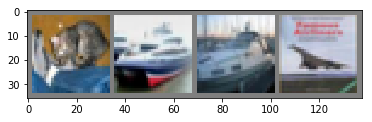

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

好的.讓我們來看看神經網路認為以上的圖片是什麼:

In [8]:
outputs = net(Variable(images))

輸出是10個類別的energy.某個類別的energy越高,神經網路越是認為該圖片是屬於某個特定類別.所以,讓我們取得energy最高的索引值.

In [9]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    dog   car  ship plane


結果看起來挺不錯的

讓我們看看神經網路對整個資料集的表現.

In [10]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted==labels).sum()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


看起來比隨機亂猜(10%)好上許多.看來神經網路真的學到了一點東西.

嗯......,哪些類別表現好,哪些類別表現不好:

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 60 %
Accuracy of  bird : 30 %
Accuracy of   cat : 15 %
Accuracy of  deer : 34 %
Accuracy of   dog : 57 %
Accuracy of  frog : 63 %
Accuracy of horse : 71 %
Accuracy of  ship : 67 %
Accuracy of truck : 77 %


好的.那接下來呢?

我們該如何在GPU上運行神經網路?

## 在GPU上訓練

正如同我們將張量轉移到GPU的方式,同理可將神經網路轉移到GPU.這會遞迴地遍歷所有模組(module)並將它們的權重與緩衝區轉為CUDA張量:

In [12]:
net.cuda()

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

記得,你也得將每一步的輸入與目標值送到GPU:

In [13]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

RuntimeError: Variable data has to be a tensor, but got Variable

為什麼我沒看到跟使用CPU相比,巨幅的加速呢?因為你的神經網路有夠小啊!

練習: 試試看加寬你的神經網路(第一個nn.Conv2d的第二個參數,以及第二個nn.Conv2d的第一個參數,它們的值必須相同).

已達成的目標:

* 高度了解PyTorch的張量庫(library)與神經網路

* 訓練了一個小型的神經網路來分類圖片

## 在多個GPU上訓練

如果你想看到使用你所有GPU後,速度的巨幅增長,請參考:http://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html